In [1]:
import os
import praw
from dotenv import load_dotenv
import json
from top2vec import Top2Vec

# Load variables from .env
load_dotenv()
client_id = os.getenv('REDDIT_CLIENT_ID')
client_secret = os.getenv('REDDIT_CLIENT_SECRET')
user_agent = os.getenv("REDDIT_USER_AGENT")


# Set up the Reddit instance
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
)

# ... rest of your code ...


/home/ilarivp/version_control/topic-browser-clash-reddit/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-30 20:22:09.632644: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-30 20:22:09.743367: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-30 20:22:09.744255: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 20:22:11.843441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [ ]:
# Define the subreddit you want to download from
subreddit = reddit.subreddit('ClashOfClans')

data = []

# Download posts
for submission in subreddit.search("flair:Discussion", sort='hot', limit=100):
    post_data = {
        "title": submission.title,
        "selftext": submission.selftext,
        "comments": []
    }
    
    # Download comments from the current post
    submission.comments.replace_more(limit=None)  # Fetch more comments if needed
    for comment in submission.comments.list():
        post_data["comments"].append(comment.body)
    
    data.append(post_data)

# Convert to JSON
json_data = json.dumps(data, indent=4)

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Downloading necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initializations
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuations and special characters
    text = re.sub(r'\W', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    # Join tokens back to string
    text = ' '.join(tokens)
    return text

# Test
sample_text = "This is a sample sentence, containing URLs https://www.example.com and numbers 12345."
print(preprocess(sample_text))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ilarivp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ilarivp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ilarivp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


sample sentence containing url number


In [6]:
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
def print_topics(model):
    topic_words, word_scores, topic_nums = model.get_topics()

    for idx, topic in enumerate(topic_nums):
        print(f"Topic {idx + 1}")
        print("-------------------")
        for word, score in zip(topic_words[idx], word_scores[idx]):
            print(word, "(Score:", score,")")
        print("\n")


def preprocess_new(text):
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    import string
    
    # Tokenize, remove punctuation, lowercase, remove stopwords
    tokens = word_tokenize(text)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    
    return tokens

def compute_coherence_for_top2vec(model):
    # Preprocess documents
    texts = [preprocess_new(doc) for doc in model.documents]

    # Create a Gensim dictionary from the preprocessed documents
    dictionary = Dictionary(texts)

    # Get topic words
    topic_words, word_scores, topic_scores = model.get_topics(len(topic_nums))

    # Compute coherence for each topic
    coherences = []
    for words in topic_words:
        cm = CoherenceModel(topics=[words], texts=texts, dictionary=dictionary, coherence='c_v')
        coherences.append(cm.get_coherence())

    return coherences



from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score

def compute_silhouette_score_for_top2vec(model, model_to_use, preprocessed_documents):
    """
    Compute the silhouette score for a given Top2Vec model.

    Parameters:
    - model: The trained Top2Vec model
    - model_to_use: The embedding model identifier for SentenceTransformer
    - preprocessed_documents: A list of preprocessed documents for embedding encoding

    Returns:
    - Silhouette score if there are multiple labels, or a message indicating there's only one label
    """

    # Retrieve document topics
    document_topics = model.get_documents_topics([i for i in range(len(model.documents))])[0]

    # Load the embedding model for SentenceTransformer
    embedding_model = SentenceTransformer(model_to_use)
    document_embeddings = embedding_model.encode(preprocessed_documents)

    # Convert topic scores to labels for silhouette scoring
    labels = document_topics

    # Calculate and return the silhouette score or a relevant message
    if len(set(labels)) > 1:
        silhouette = silhouette_score(document_embeddings, labels)
        return silhouette
    else:
        return "Cannot compute silhouette score for a single label"



In [15]:
documents = []
for post in data:
    combined_text =  post['selftext'] + ' ' + ' '.join(post['comments'])
    documents.append(combined_text)
preprocessed_documents = [preprocess(doc) for doc in documents]
preprocessed_documents = [doc for doc in preprocessed_documents if doc.strip()]

umap_args = {
    'n_neighbors': 15,  # You can play around with this number.
    'n_components': 5,
    'metric': 'cosine'
}


hdbscan_args = {
    'min_cluster_size': 10,  # Adjust this as needed
    'min_samples': 5,       # Adjust this as needed
    'metric': 'euclidean',  # or 'cosine', etc.
    'cluster_selection_method': 'eom'  # or 'leaf'
}

umap_args = {'n_neighbors': 20,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42}
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'l1',
                'cluster_selection_method': 'leaf'}

model_to_use = 'distiluse-base-multilingual-cased'
model_to_use = 'distiluse-base-multilingual-cased'

model = Top2Vec(
    preprocessed_documents,
    min_count = 10,
    embedding_model=model_to_use,
    workers=4,
    umap_args=umap_args,
    hdbscan_args=hdbscan_args
)

# model = Top2Vec(documents, embedding_model='distiluse-base-multilingual-cased', workers=4)
topic_sizes, topic_nums = model.get_topic_sizes()
print(topic_sizes)
coherences = compute_coherence_for_top2vec(model)
for idx, coherence in enumerate(coherences):
    print(f"Topic {idx}, Coherence Score: {coherence.round(4)}")

average_coherence = sum(coherences) / len(coherences)
print(f"Average Coherence Score: {average_coherence.round(4)}")


# Usage example:
result = compute_silhouette_score_for_top2vec(model, model_to_use, preprocessed_documents)
print(f"Silhouette Score: {str(result.round(4))}")

2023-09-30 20:59:33,677 - top2vec - INFO - Pre-processing documents for training
/home/ilarivp/version_control/topic-browser-clash-reddit/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2023-09-30 20:59:33,865 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
2023-09-30 20:59:36,358 - top2vec - INFO - Creating joint document/word embedding
2023-09-30 20:59:51,959 - top2vec - INFO - Creating lower dimension embedding of documents
/home/ilarivp/version_control/topic-browser-clash-reddit/venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
2023-09-30 20:59:53,205 - top2vec - INFO - Finding dense areas of documents
2023-09-30 20:59:5

[43 32 25]
Topic 0, Coherence Score: 0.2641
Topic 1, Coherence Score: 0.38
Topic 2, Coherence Score: 0.3721
Average Coherence Score: 0.3388
Silhouette Score: 0.0445


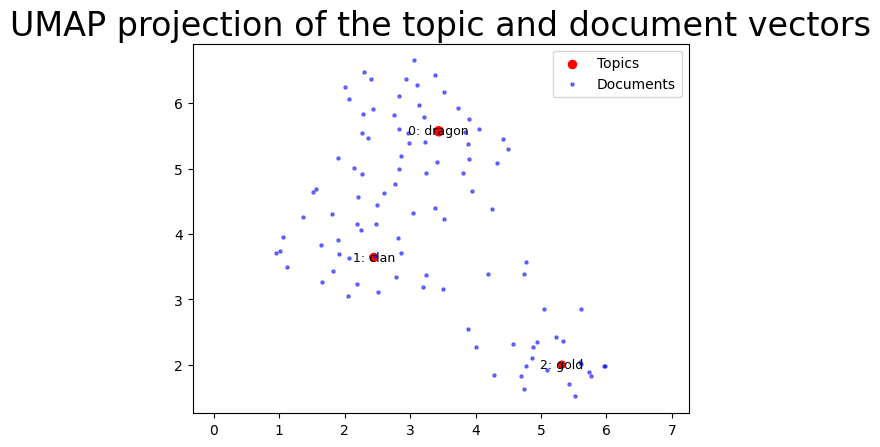

In [23]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

# 1. Get topic vectors, their weights, and the top words for each topic
topic_weights, _ = model.get_topic_sizes()
topic_vectors = model.topic_vectors
topic_words, word_scores, topic_nums = model.get_topics()

# Use the first word from each topic's list as the top word
top_words = [words[0] for words in topic_words]

# 2. Get document vectors
document_vectors = model.document_vectors

# 3. Combine topic vectors and document vectors for UMAP transformation
all_vectors = np.vstack([topic_vectors, document_vectors])

# 4. Reduce dimensions using UMAP on the combined set of vectors
reducer = umap.UMAP(init='random')
embedding = reducer.fit_transform(all_vectors)

# Split the embeddings back into topics and documents
topic_embedding = embedding[:len(topic_vectors)]
document_embedding = embedding[len(topic_vectors):]

# 5. Plot the embeddings

# Plotting topic vectors with their weights
plt.scatter(topic_embedding[:, 0], topic_embedding[:, 1], s=topic_weights, c='red', label='Topics')

# Plotting document vectors (adjust size and alpha to your preference)
plt.scatter(document_embedding[:, 0], document_embedding[:, 1], s=5, alpha=0.5, c='blue', label='Documents')

# Annotate each topic number along with the top word from the topic
for i, num in enumerate(topic_nums):
    annotation = f"{num}: {top_words[i]}"
    plt.annotate(annotation, (topic_embedding[i, 0], topic_embedding[i, 1]), fontsize=9, ha='center', va='center')

# Adjusting the plot visuals
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the topic and document vectors', fontsize=24)
plt.legend()
plt.show()


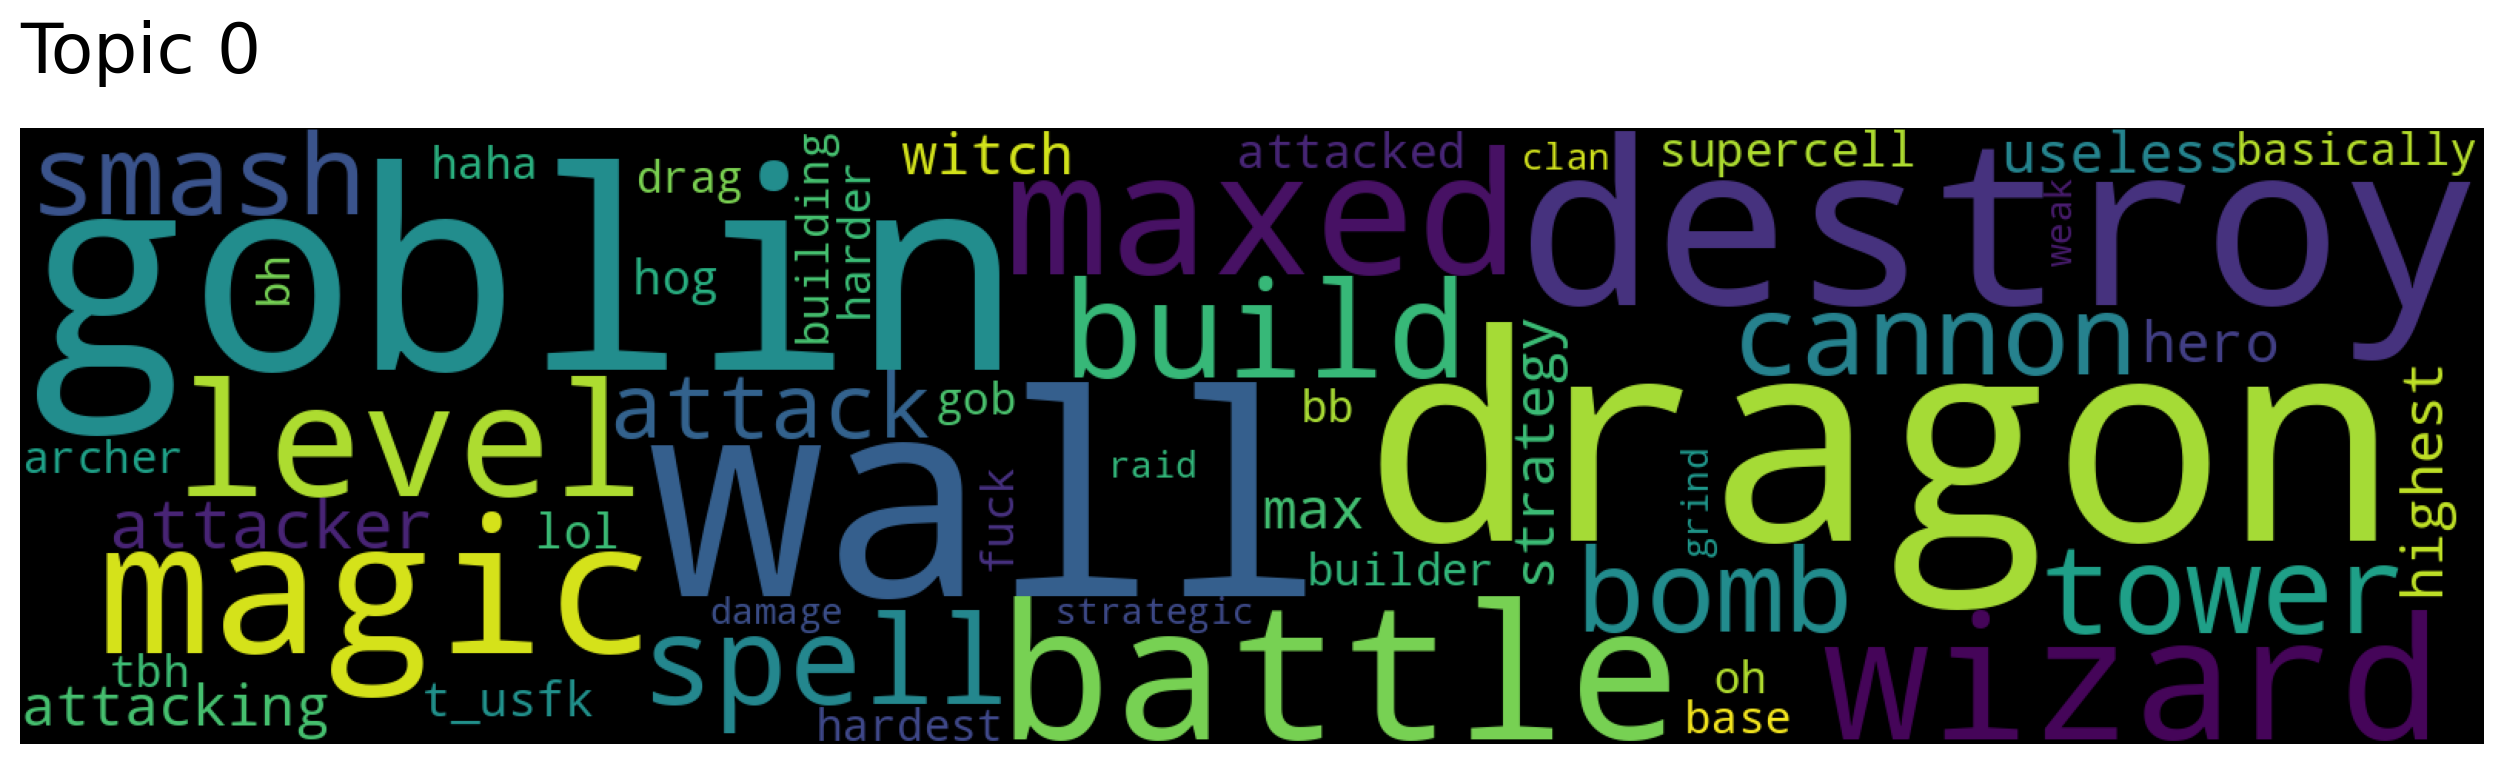

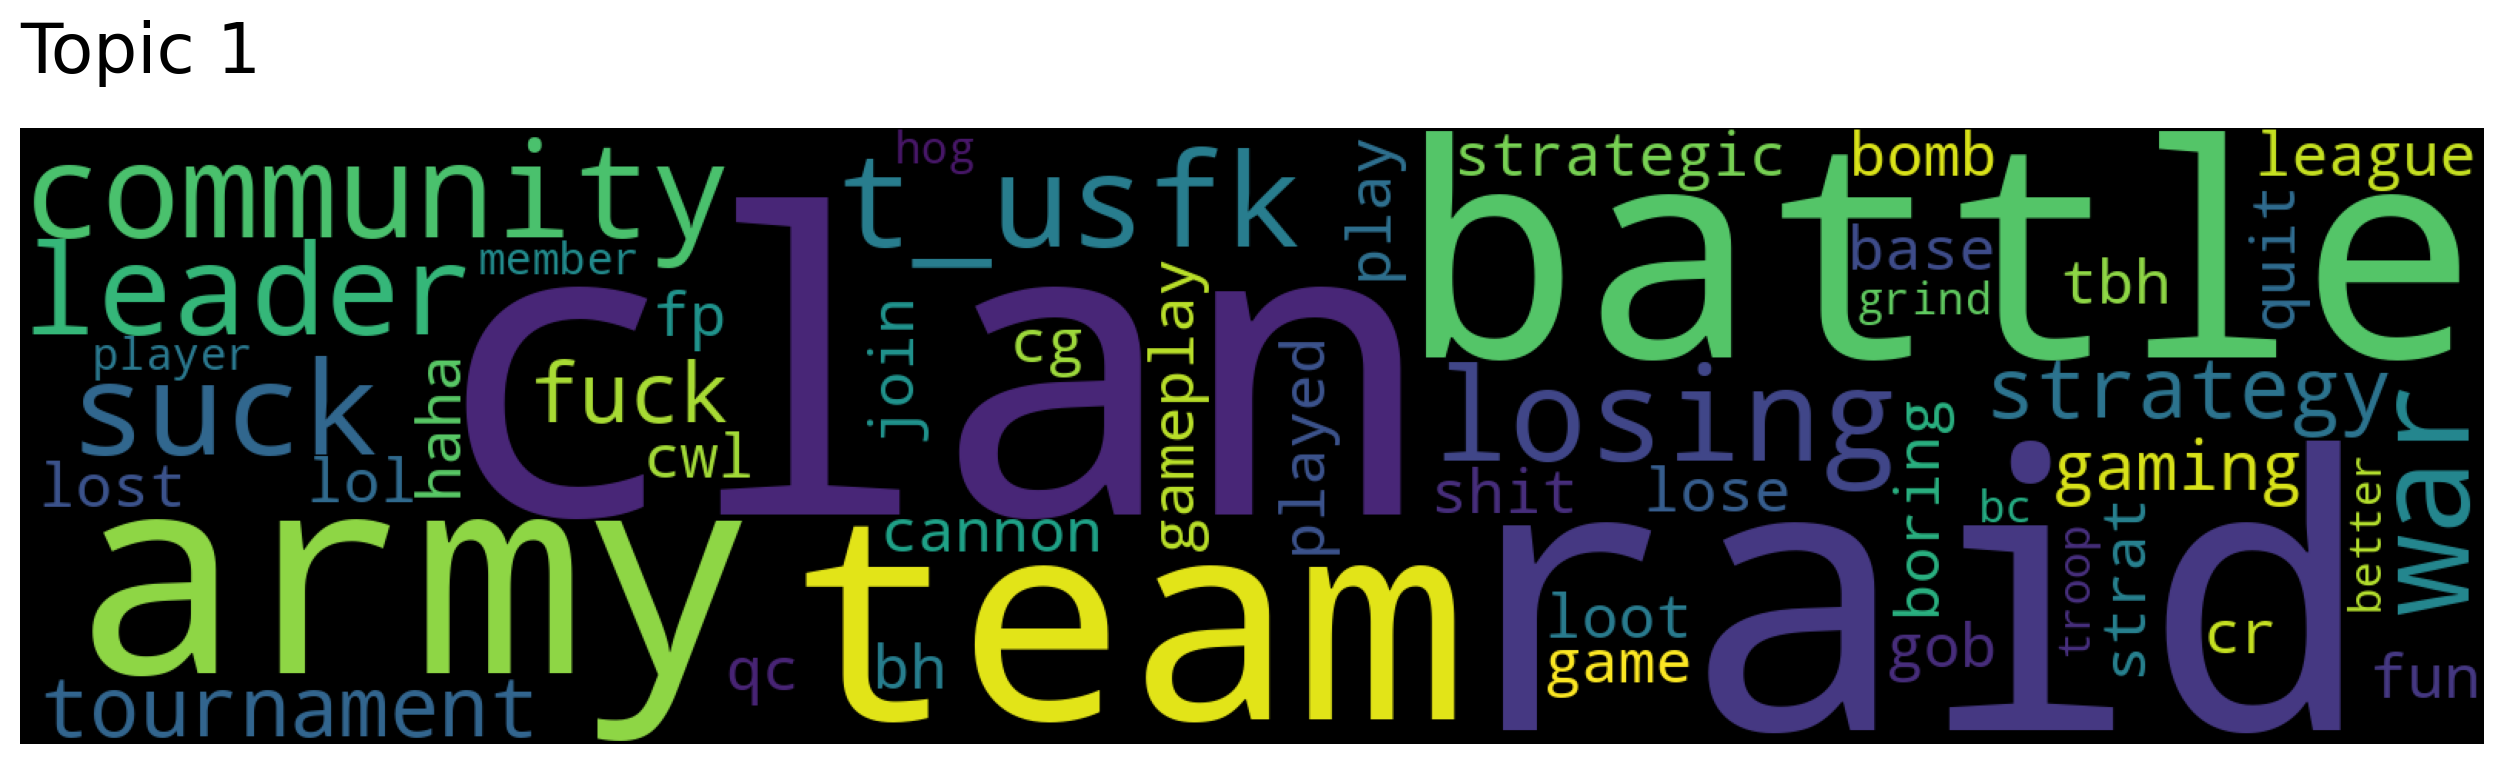

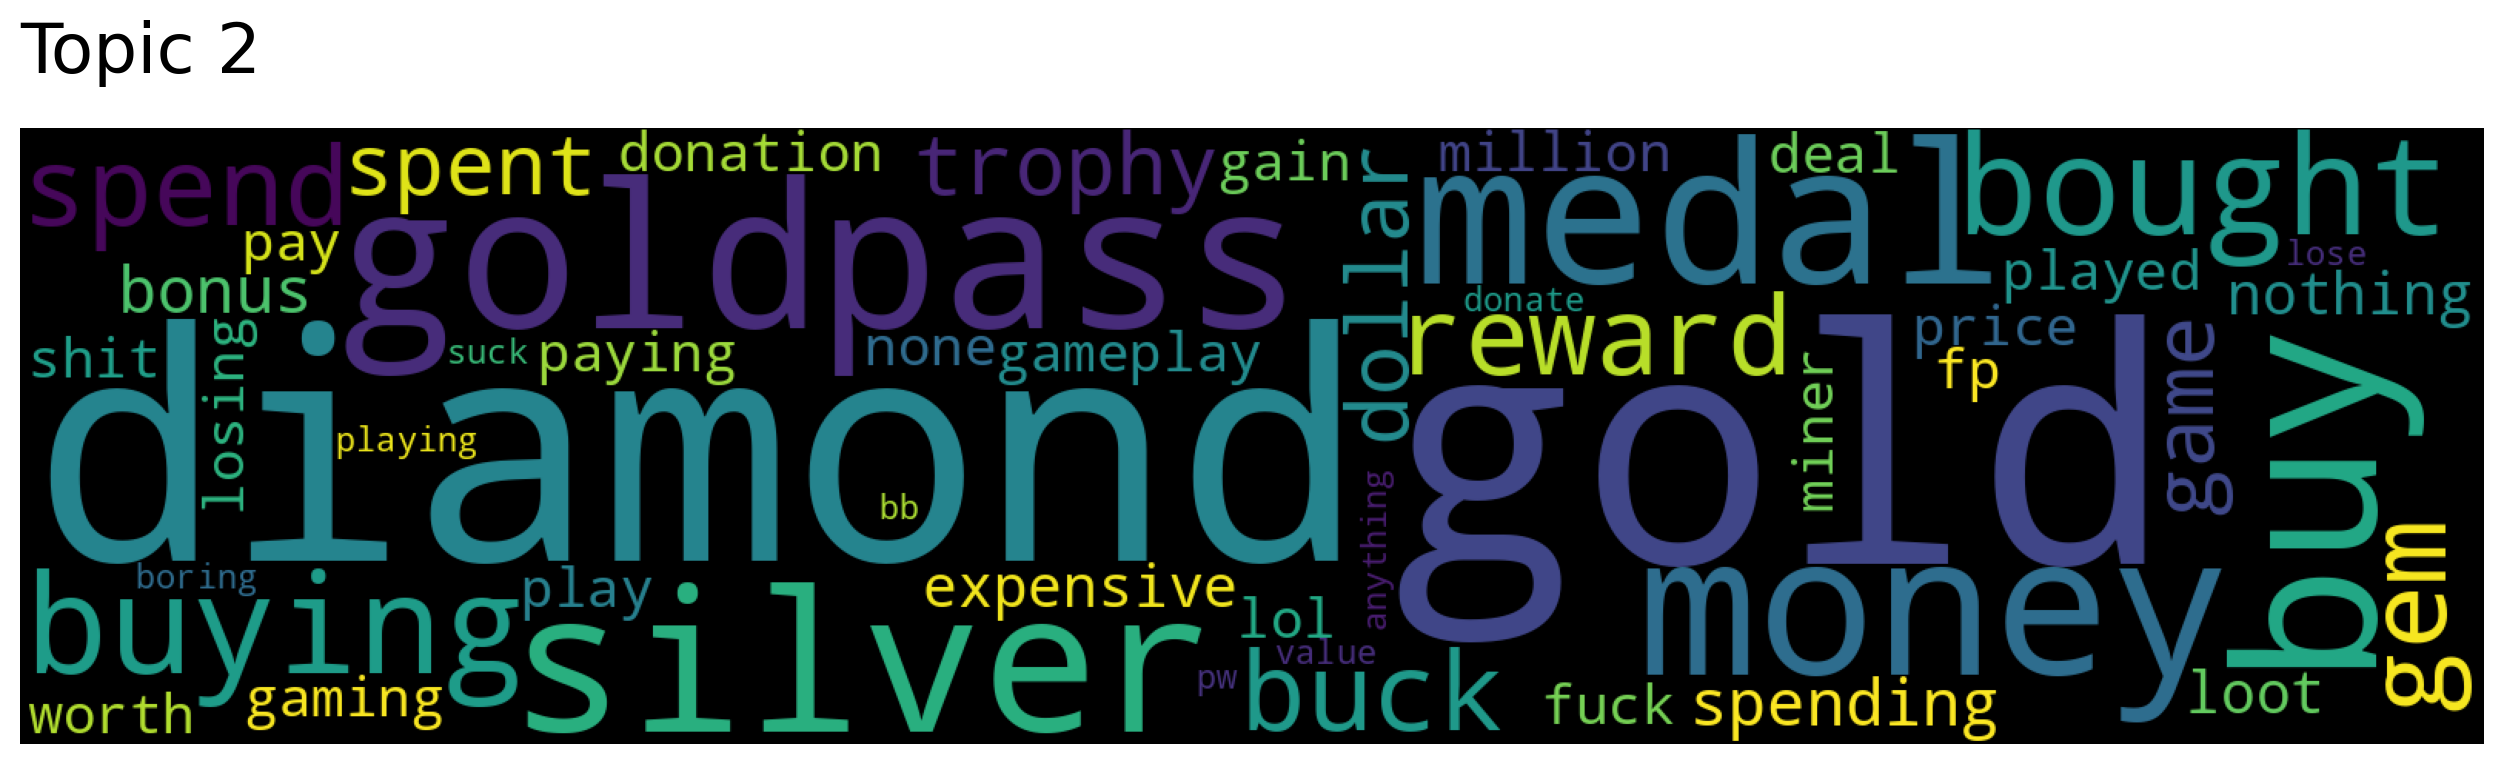

In [16]:
topic_sizes, topic_nums = model.get_topic_sizes()
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)